# YouTube URL Analysis

## Preface
### Data descriptions

In [150]:
#sample_size = 100000000 # specifies the sample size
sample_size = 10000000 # specifies the sample size
limit = 15 # specifies the number of elements in lists and graphs

url_columns = ["id","hash","channelId","publishedAt","url","resolvedUrl","domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [151]:


import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})

### Load data

In [152]:
# load and clean URLs csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv')
pd_url_data.columns = url_columns

# add year column, based on publishedAt
pd_url_data['year'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.year
pd_url_data['date'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.date

# skip everything before december 2019
pd_url_data = pd_url_data[pd_url_data['date'] < datetime.date(year=2019,month=12,day=1)]

In [153]:
# load and clean channel data
pd_channel_data = pd.read_csv('channel_data/channels_from_jsoncache_100k_update.csv')
pd_channel_data.columns = channel_columns

# join with url data on channelId
pd_url_data = pd_url_data.join(pd_channel_data.set_index('id'), on='channelId', lsuffix='_urls', rsuffix='_channel')

In [154]:
print(pd_channel_data.head())

                         id             title  \
0  UC8VddvuHJzIj__Ud0rY2_ww   Red Bull Gaming   
1  UCIHvPGAv98olIvBVOYG4TMg         Конопатый   
2  UCncYADZcQqRHQr-riOE-oog  الخياطة والإبداع   
3  UCZN0QSFNnMUTVA_-7UqdRaQ    Лудия репортер   
4  UCMmum-l1QGZLhD2XPaX1pCw  Irja Nailal Ulya   

                                         description  subscriberCount  \
0  This is Red Bull Gaming; your digital source f...           200000   
1  Привет мои дорогие Подпиздики! Меня зовут Тёма...           175000   
2  السلام عليكم أخواتي و عزيزاتي معكم اختكم جميلة...           340000   
3  Колоритният репортер от „Часът на Милен Цветко...           173000   
4  Haloo, saya Irja Nailal Ulya. Disini saya akan...           311000   

   videoCount  commentCount  viewCount  featuring  subscribing country  \
0         518             0   51647167          5            0      US   
1          64             0    8859907          7            0      RU   
2         311             0   16940703      

### clean domains

In [155]:
# remove all www. or www2.
pd_url_data.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True) 

# replace all open.spotify.com by spotify.com
pd_url_data.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True) 

# @todo: check domains and see whether more needs to be replaced

# Generic analysis

In [156]:
print("min date: %s, max date: %s\n" % (min(pd_url_data.date),max(pd_url_data.date)))
print("Basic stats on int/float columns")
print(pd_url_data.describe())

min date: 2005-11-19, max date: 2019-11-30

Basic stats on int/float columns
                 id      resolved          dead   status_code          year  \
count  9.882955e+06  9.882955e+06  9.882955e+06  3.453105e+06  9.882955e+06   
mean   2.888511e+08  8.415110e-01  3.533599e-02  2.247743e+02  2.016876e+03   
std    1.668060e+08  3.651990e-01  1.846276e-01  9.306170e+01  2.013253e+00   
min    1.270000e+02  0.000000e+00  0.000000e+00  0.000000e+00  2.005000e+03   
25%    1.443379e+08  1.000000e+00  0.000000e+00  2.000000e+02  2.016000e+03   
50%    2.888739e+08  1.000000e+00  0.000000e+00  2.000000e+02  2.017000e+03   
75%    4.333160e+08  1.000000e+00  0.000000e+00  2.000000e+02  2.018000e+03   
max    5.777380e+08  1.000000e+00  1.000000e+00  9.990000e+02  2.019000e+03   

       subscriberCount    videoCount  commentCount     viewCount  \
count     9.882888e+06  9.882888e+06     9882888.0  9.882888e+06   
mean      1.489334e+06  2.197603e+04           0.0  7.559173e+08   
std    

## Check 'dead' URLs + how many have not yet been checked 
When less than 5%, just leave it as is

@todo: too many unchecked URLs

In [157]:
# count URLs marked as dead on expansion and sort in reverse
pd_url_data_dead = len(pd_url_data.query("dead==1"))
# count total number of URLs
total = len(pd_url_data)
# calculate percentage
percent_dead = round(pd_url_data_dead/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total,pd_url_data_dead,percent_dead)) 

# unchecked if resolved = 0 and dead = 0
pd_url_data_unchecked = len(pd_url_data.query('resolved==0 & dead==0'))
percent_unchecked = round(pd_url_data_unchecked/total*100,2)
print("Total URLS: %s, of which %s (%s%%) NOT yet checked" % (total,pd_url_data_unchecked,percent_unchecked)) 

Total URLS: 9882955, of which 349224 (3.53%) dead
Total URLS: 9882955, of which 1221782 (12.36%) NOT yet checked


## Basic stats (based on videos, not channels)
### Top domains

In [158]:
# add count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
print(pd_url_data_groupedDomain.head(limit)) 

Top 15 domains
domain
youtube.com            3149280
facebook.com           1128728
twitter.com             904783
instagram.com           532276
google.com              207338
twitch.tv                98152
vk.com                   93561
soundcloud.com           53613
play.google.com          53275
amazon.com               47750
accounts.google.com      43964
itunes.apple.com         42586
pinterest.com            40703
patreon.com              37553
amazon.de                27435
Name: count, dtype: int64


### Top deep links

In [159]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
print(pd_url_data_groupedUrl.head(limit)) 

Top 15 resolvedUrl
resolvedUrl
https://www.youtube.com/error?src=404                    7948
https://unacademy.com/unavailable                        7773
https://www.youtube.com/user/euronewsnetwork/channels    7291
https://www.facebook.com/euronews                        6826
http://incompetech.com/                                  6308
https://www.zee5.com/                                    6070
https://creativecommons.org/licenses/by/4.0/)            5937
https://www.youtube.com/playlist?list...                 5461
https://www.zee5.com                                     5393
https://www.instagram.com/zee5                           5121
https://twitter.com/ZEE5India                            5088
https://www.facebook.com/ZEE5/                           5026
http://creativecommons.org/licenses/by/3.0/              4694
https://onlinedatinglogic.com/forums/forum/qa/           4488
https://datinglogic.net/forums/forum/qa/                 4383
Name: count, dtype: int64


### Top TLDs

In [160]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) 
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False)
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
print(pd_url_data_groupedTld.head(limit))

Top 15 TLDs
tld
com    7430898
tv      167989
net      65496
de       48885
in       48607
org      48027
me       39577
ru       37033
br       29566
kr       29414
gg       27179
co       22983
jp       20884
st       19525
uk       16700
Name: count, dtype: int64


### Top domains per TLD

In [161]:
# for each tld, get limit domain
print("Top domains per TLD")
for tld in pd_url_data_groupedTld.head(limit).keys():
    top_domains_for_tld = pd_url_data[pd_url_data['tld']==tld].groupby(['tld','domain'])['hash'].nunique().sort_values(ascending=False)
    print(top_domains_for_tld[:limit])
    

Top domains per TLD
tld  domain             
com  youtube.com            2904328
     facebook.com           1122989
     twitter.com             901601
     instagram.com           529885
     google.com              206743
     vk.com                   92698
     play.google.com          53194
     soundcloud.com           53069
     amazon.com               45315
     accounts.google.com      43916
     itunes.apple.com         42295
     pinterest.com            40671
     patreon.com              37498
     apps.apple.com           25918
     tumblr.com               24424
Name: hash, dtype: int64
tld  domain         
tv   twitch.tv          96389
     tfc.tv              1939
     espreso.tv          1848
     ruptly.tv           1693
     ns7.tv              1658
     lahorenews.tv       1642
     qazaqstan.tv        1515
     sathiyam.tv         1496
     britishpathe.tv     1393
     beritasatu.tv       1366
     samaa.tv            1364
     city42.tv           1352
     somo

# Monetization

## Allowed merch and monetization on Github (by Bernhard)

In [162]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd
print("Number of merch sites: %s" % (len(merch)))
print("Number of crowd sites: %s" % (len(crowd)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

Number of merch sites: 191
Number of crowd sites: 85


## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [163]:
# make a column where at least one of monetized or crowd is true
monetized = pd_url_data['merch'] | pd_url_data['crowd'] 
pd_url_data['monetized'] = monetized

# get number of video ids where monetized = True
monetized_videos = pd_url_data[pd_url_data['monetized']==True]['hash'].unique()
monetized_video_number = len(monetized_videos)
total_video_number = len(pd_url_data['hash'].unique())
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)
# do the same for channels
monetized_channels = pd_url_data[pd_url_data['monetized']==True]['channelId'].unique()
monetized_channel_number = len(monetized_channels)
total_channel_number = len(pd_url_data['channelId'].unique())
percent_channel_monetized = round(monetized_channel_number/total_channel_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))
print("%s channels are monetized out of %s total channels, that is %s%%" % (monetized_channel_number,total_channel_number,percent_channel_monetized))

199222 videos are monetized out of 9016955 total videos, that is 2.21%
23099 channels are monetized out of 118909 total channels, that is 19.43%


### Channel and domain counts

In [164]:
# count unique videos for each channel
videoCountForChannel = pd_url_data.groupby('channelId')['hash'].nunique()
# add videoCountForChannel as column
pd_url_data['videoCountForChannel'] = pd_url_data['channelId'].map(videoCountForChannel)

# count unique videos for each domain
videoCountForDomain = pd_url_data.groupby('domain')['hash'].nunique()
# add videoCountForDomain as column
pd_url_data['videoCountForDomain'] = pd_url_data['domain'].map(videoCountForDomain)

# count unique channels for domain
channelCountForDomain = pd_url_data.groupby('domain')['channelId'].nunique()
# add channelCountForDomain as column
pd_url_data['channelCountForDomain'] = pd_url_data['domain'].map(channelCountForDomain)

# add log(channels/videos) for domains
pd_url_data['channelDivVideoForDomain'] = pd_url_data['channelCountForDomain']/pd_url_data['videoCountForDomain']

## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type
Beware: below calculations assume that merch or crowd URLs are only mentioned once per video


crowd domain count
                 domain  channelCountForDomain  videoCountForDomain  \
117         patreon.com                 5803.0              37498.0   
1096     streamlabs.com                 2228.0              11303.0   
23802      gofundme.com                  296.0               1265.0   
8170           apoia.se                  287.0               1656.0   
63120   kickstarter.com                  261.0                387.0   
9438         tipeee.com                  196.0                849.0   
20606     indiegogo.com                  143.0                280.0   
19352      patronite.pl                  113.0                680.0   
67468        change.org                   87.0                334.0   
214431   vakinha.com.br                   68.0                153.0   
70204    justgiving.com                   27.0                 81.0   
348855       catarse.me                   27.0                122.0   
333885  kickante.com.br                   15.0            

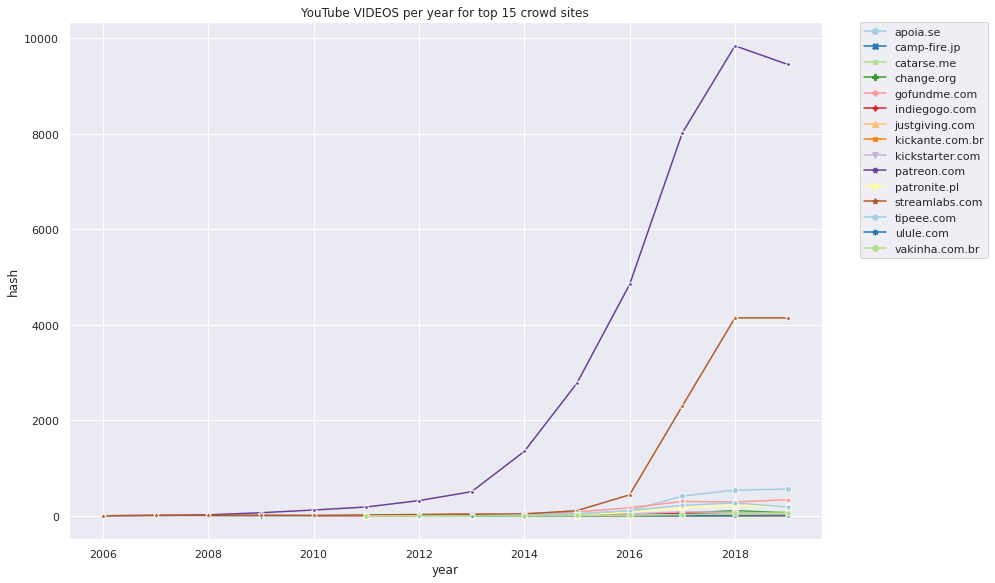

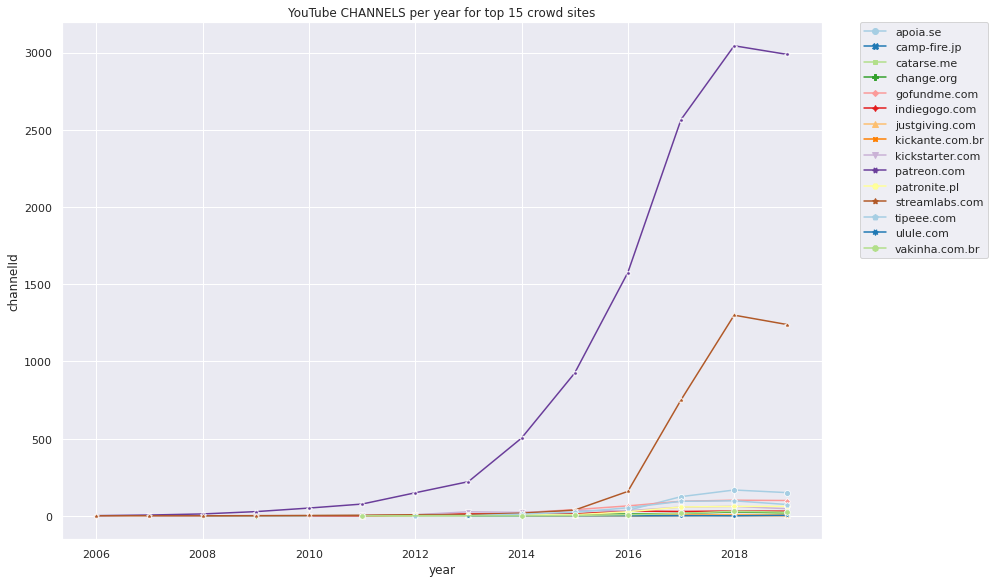

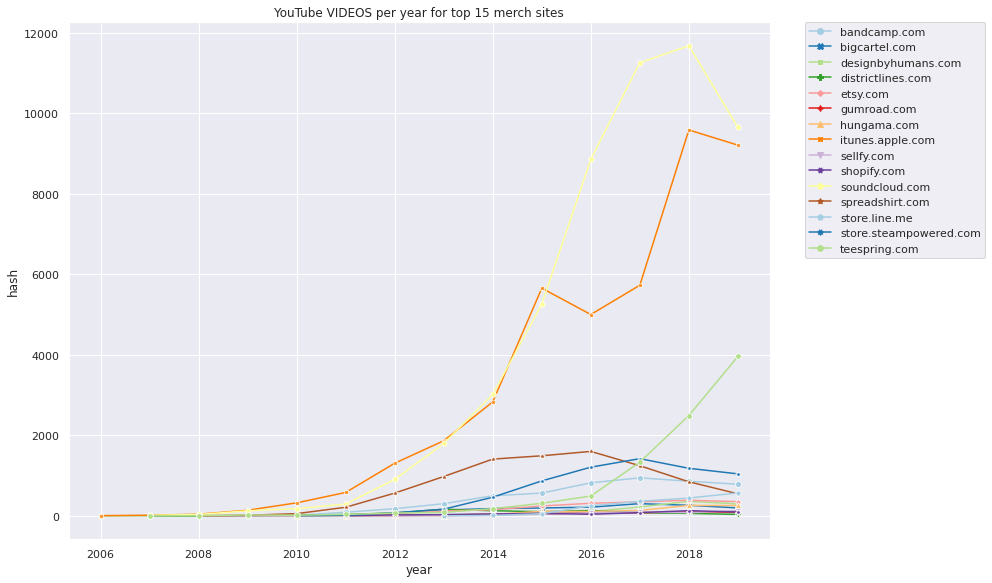

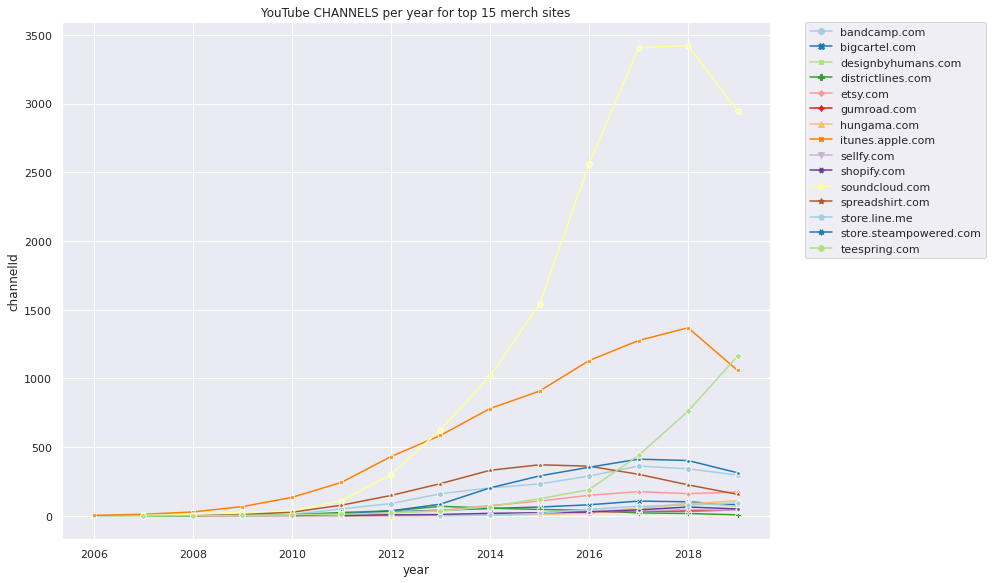

In [165]:
domain_stats = {}
for type in ['crowd','merch']:

    ''' Describe '''
    domain_stats[type] = pd_url_data[['domain','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']][pd_url_data[type]==True].drop_duplicates()

    # print header
    print("%s domain count" % type)
    # print most used TYPE domains
    print(domain_stats[type].sort_values(by=['channelCountForDomain','channelDivVideoForDomain'],ascending=False).head(limit))
    print("\n")
    # print TYPE domain stats
    print("%s domain stats" % type)
    print(domain_stats[type].describe())
    print("\n")

    ''' Graph '''

    # filter pd_url_data to only retain info for rows with TYPE domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]

    # limit data by top overall TYPE domain for graph
    top_domains = {}
    top_domains[type] = domain_stats[type].sort_values(by="channelCountForDomain",ascending=False)['domain'][0:limit]
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count videos by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['hash'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)
    print(filtered_limited_count[type].head())

    # plot rise of TYPE sites, for videos per year
    plt.figure()
    sns.lineplot(x="year", y="hash", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube VIDEOS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    # count channels by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['channelId'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)
    print(filtered_limited_count[type].head())

    # plot rise of TYPE sites, for channels per year
    plt.figure()
    sns.lineplot(x="year", y="channelId", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube CHANNELS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## @todo

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Channel categories. What hasn't been done at all in the last paper is looking at video categories. That may be done interestingly. Monetization per channel category. Channel classification is not done by video creators. 
	   * b = DataFrame(a.var1.str.split('|').tolist(), index=a.var2).stack()
	   * b = b.reset_index()[[0, 'var2']] # var1 variable is currently labeled 0
	   * b.columns = ['var1', 'var2'] # renaming var1
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Compare channel categories vs video categories. (But we need to import mysql database.) Is gonna be important when looking at descriptions and tags and such.
* Think of categories in terms of scatter plots. E.g. crowd funding vs merch and category. Size is number of videos.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Various
* create list of "commission"
	* Official YT merch list = https://support.google.com/youtube/answer/6083754?hl=en#zippy=%2Clist-of-approved-merchandise-sites
* Domains: open.spotify.com, spotify.com, play.google.com, accounts.google.com, etc. (Does play.google.com has a commission?)

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)

Later
* what kind of channels linked to the academic publishers?
* look into what's missing. The "(note-)book" of the dead.
	* https://www.youtube.com/error?src=404
	* unacademy.com/unavailable
* graphs, instead of absolute numbers, divide into number of videos per year
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 